In [1]:
!pip -q install imbalanced-learn xgboost

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay
)
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import joblib, os, warnings
warnings.filterwarnings("ignore")


In [3]:
from google.colab import files
up = files.upload()  # choose your CSV
csv_path = list(up.keys())[0]

df = pd.read_csv(csv_path)
print(df.shape)
df.head()

Saving WA_Fn-UseC_-HR-Employee-Attrition.csv to WA_Fn-UseC_-HR-Employee-Attrition (1).csv
(1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
# Columns we know are useless/constant in this IBM HR dataset
drop_cols = [c for c in ['EmployeeCount','Over18','StandardHours','EmployeeNumber'] if c in df.columns]
df = df.drop(columns=drop_cols, errors='ignore')

# Ensure target exists and is clean
target_col = 'Attrition'
assert target_col in df.columns, "Couldn't find 'Attrition' column."

# Basic info
print("Missing values per column:\n", df.isna().sum().sort_values(ascending=False).head(10))
print("\nTarget distribution:\n", df[target_col].value_counts())

# Simple missing-value handling (optional: tweak later)
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())
for col in df.select_dtypes(exclude=[np.number]).columns:
    df[col] = df[col].fillna(df[col].mode()[0])


Missing values per column:
 Age                        0
Attrition                  0
BusinessTravel             0
DailyRate                  0
Department                 0
DistanceFromHome           0
Education                  0
EducationField             0
EnvironmentSatisfaction    0
Gender                     0
dtype: int64

Target distribution:
 Attrition
No     1233
Yes     237
Name: count, dtype: int64


In [5]:
X = df.drop(columns=[target_col])
y = df[target_col].map({'Yes':1, 'No':0})  # convert to 0/1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)


Train size: (1176, 30)  Test size: (294, 30)


In [7]:
# Column selectors
num_cols = selector(dtype_include=np.number)(X_train)
cat_cols = selector(dtype_exclude=np.number)(X_train)

# Preprocessor: OneHot -> dense output (so SMOTE can work)
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols),
    ],
    remainder='drop'
)

# Feature selector (keeps features with importance above the median)
feature_selector = SelectFromModel(
    RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight='balanced', n_jobs=-1
    ),
    threshold="median"
)

In [8]:
# Define three models
log_reg = LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=-1 if hasattr(LogisticRegression(), "n_jobs") else None)
rf = RandomForestClassifier(n_estimators=600, random_state=42, class_weight='balanced', n_jobs=-1)
xgb = XGBClassifier(
    n_estimators=600, learning_rate=0.05, max_depth=6, subsample=0.9, colsample_bytree=0.9,
    reg_lambda=1.0, random_state=42, objective='binary:logistic', eval_metric='logloss', n_jobs=-1, tree_method='hist'
)

# Build three pipelines: preprocess -> select -> SMOTE -> model
def make_pipeline(model):
    return ImbPipeline(steps=[
        ('preprocess', preprocess),
        ('select', feature_selector),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

pipelines = {
    'LogisticRegression': make_pipeline(log_reg),
    'RandomForest': make_pipeline(rf),
    'XGBoost': make_pipeline(xgb)
}



=== LogisticRegression ===
Accuracy: 0.714 | Precision: 0.317 | Recall: 0.681 | F1: 0.432 | ROC-AUC: 0.782

Classification report:
               precision    recall  f1-score   support

          No       0.92      0.72      0.81       247
         Yes       0.32      0.68      0.43        47

    accuracy                           0.71       294
   macro avg       0.62      0.70      0.62       294
weighted avg       0.83      0.71      0.75       294

Confusion matrix:
 [[178  69]
 [ 15  32]]


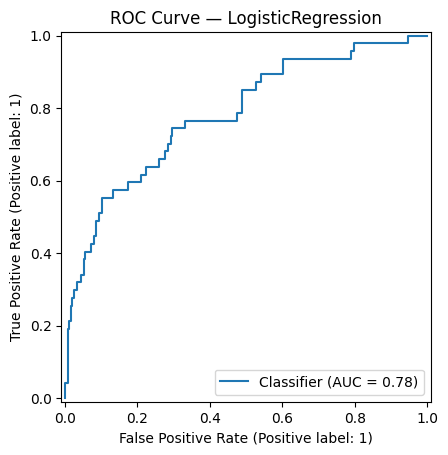


=== RandomForest ===
Accuracy: 0.847 | Precision: 0.545 | Recall: 0.255 | F1: 0.348 | ROC-AUC: 0.819

Classification report:
               precision    recall  f1-score   support

          No       0.87      0.96      0.91       247
         Yes       0.55      0.26      0.35        47

    accuracy                           0.85       294
   macro avg       0.71      0.61      0.63       294
weighted avg       0.82      0.85      0.82       294

Confusion matrix:
 [[237  10]
 [ 35  12]]


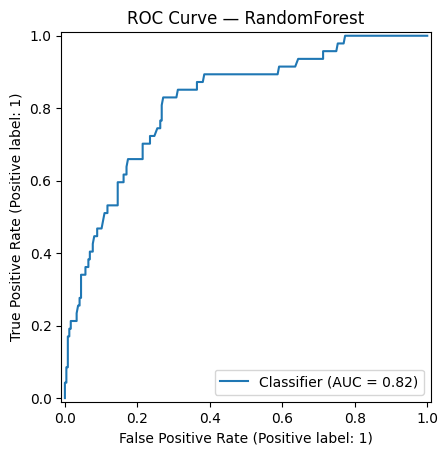


=== XGBoost ===
Accuracy: 0.857 | Precision: 0.632 | Recall: 0.255 | F1: 0.364 | ROC-AUC: 0.789

Classification report:
               precision    recall  f1-score   support

          No       0.87      0.97      0.92       247
         Yes       0.63      0.26      0.36        47

    accuracy                           0.86       294
   macro avg       0.75      0.61      0.64       294
weighted avg       0.83      0.86      0.83       294

Confusion matrix:
 [[240   7]
 [ 35  12]]


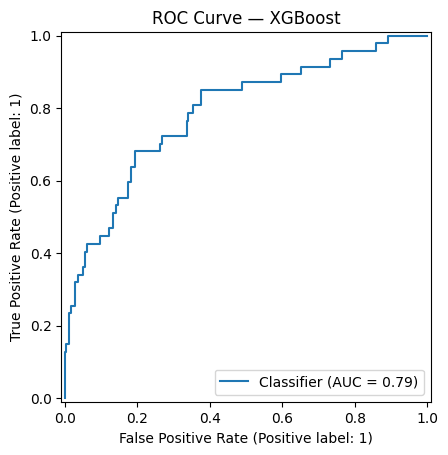

In [9]:
def evaluate(model_name, pipe, X_tr, y_tr, X_te, y_te):
    pipe.fit(X_tr, y_tr)
    proba = pipe.predict_proba(X_te)[:,1]
    pred  = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_te, pred)
    prec = precision_score(y_te, pred, zero_division=0)
    rec = recall_score(y_te, pred)
    f1 = f1_score(y_te, pred)
    roc = roc_auc_score(y_te, proba)

    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {roc:.3f}")
    print("\nClassification report:\n", classification_report(y_te, pred, target_names=['No','Yes']))
    print("Confusion matrix:\n", confusion_matrix(y_te, pred))

    RocCurveDisplay.from_predictions(y_te, proba)
    plt.title(f"ROC Curve — {model_name}")
    plt.show()

    return {'model': model_name, 'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1, 'roc':roc, 'pipe':pipe}

results = []
for name, pipe in pipelines.items():
    results.append(evaluate(name, pipe, X_train, y_train, X_test, y_test))


In [10]:
res_df = pd.DataFrame([{k:v for k,v in r.items() if k!='pipe'} for r in results]).sort_values('roc', ascending=False)
res_df
best = max(results, key=lambda r: r['roc'])
print("\nBest model by ROC-AUC:", best['model'])



Best model by ROC-AUC: RandomForest


In [12]:
best_pipe = best['pipe']

def group_metrics(df_eval, group_col, pipe):
    tmp = df_eval.copy()
    Xg = tmp.drop(columns=[target_col])
    yg = tmp[target_col].map({'Yes':1,'No':0})
    proba = pipe.predict_proba(Xg)[:,1]
    pred  = (proba >= 0.5).astype(int)

    out = []
    for g, idx in tmp.groupby(group_col).groups.items():
        y_true = yg.loc[idx].reset_index(drop=True)
        y_pred = pred[y_true.index]
        y_p = proba[y_true.index]
        out.append({
            group_col: g,
            'count': len(idx),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_true, y_p) if len(np.unique(y_true))>1 else np.nan
        })
    return pd.DataFrame(out).sort_values('count', ascending=False)

# Gender
if 'Gender' in X_test.columns:
    print("\nFairness by Gender:")
    display(group_metrics(pd.concat([X_test, y_test.map({1:'Yes',0:'No'}).rename('Attrition')], axis=1), 'Gender', best_pipe))

# Age bands
if 'Age' in X_test.columns:
    X_test_ageband = X_test.copy()
    X_test_ageband['AgeBand'] = pd.cut(X_test['Age'], bins=[0,29,39,49,120], labels=['<=29','30-39','40-49','50+'])
    print("\nFairness by Age Band:")
    display(group_metrics(pd.concat([X_test_ageband, y_test.map({1:'Yes',0:'No'}).rename('Attrition')], axis=1), 'AgeBand', best_pipe))


Fairness by Gender:


,Gender,count,precision,recall,f1,roc_auc
1,Male,178,0.153846,0.064516,0.090909,0.554202
0,Female,116,0.100000,0.062500,0.076923,0.429063



Fairness by Age Band:


,AgeBand,count,precision,recall,f1,roc_auc
1,30-39,125,0.200000,0.142857,0.166667,0.528636
0,<=29,68,0.500000,0.176471,0.260870,0.534602
2,40-49,67,0.166667,0.125000,0.142857,0.625000
3,50+,34,0.500000,0.250000,0.333333,0.283654


In [15]:
def predict_single_employee(model):
    print("Enter employee details to predict attrition risk:")

    # We'll only ask for important features — you can add/remove as needed
    data = {
        'Age': int(input("Age: ")),
        'BusinessTravel': input("BusinessTravel (Non-Travel / Travel_Rarely / Travel_Frequently): "),
        'DailyRate': int(input("DailyRate: ")),
        'Department': input("Department (Sales / Research & Development / Human Resources): "),
        'DistanceFromHome': int(input("DistanceFromHome: ")),
        'Education': int(input("Education (1-5): ")),
        'EducationField': input("EducationField (Life Sciences / Medical / Marketing / Technical Degree / Human Resources / Other): "),
        'EnvironmentSatisfaction': int(input("EnvironmentSatisfaction (1-4): ")),
        'Gender': input("Gender (Male / Female): "),
        'HourlyRate': int(input("HourlyRate: ")),
        'JobInvolvement': int(input("JobInvolvement (1-4): ")),
        'JobLevel': int(input("JobLevel (1-5): ")),
        'JobRole': input("JobRole (Sales Executive / Research Scientist / Laboratory Technician / ...): "),
        'JobSatisfaction': int(input("JobSatisfaction (1-4): ")),
        'MaritalStatus': input("MaritalStatus (Single / Married / Divorced): "),
        'MonthlyIncome': int(input("MonthlyIncome: ")),
        'MonthlyRate': int(input("MonthlyRate: ")),
        'NumCompaniesWorked': int(input("NumCompaniesWorked: ")),
        'OverTime': input("OverTime (Yes / No): "),
        'PercentSalaryHike': int(input("PercentSalaryHike: ")),
        'PerformanceRating': int(input("PerformanceRating (1-4): ")),
        'RelationshipSatisfaction': int(input("RelationshipSatisfaction (1-4): ")),
        'StockOptionLevel': int(input("StockOptionLevel (0-3): ")),
        'TotalWorkingYears': int(input("TotalWorkingYears: ")),
        'TrainingTimesLastYear': int(input("TrainingTimesLastYear: ")),
        'WorkLifeBalance': int(input("WorkLifeBalance (1-4): ")),
        'YearsAtCompany': int(input("YearsAtCompany: ")),
        'YearsInCurrentRole': int(input("YearsInCurrentRole: ")),
        'YearsSinceLastPromotion': int(input("YearsSinceLastPromotion: ")),
        'YearsWithCurrManager': int(input("YearsWithCurrManager: "))
    }

    # Convert to DataFrame with one row
    df_input = pd.DataFrame([data])

    # Predict
    prob = model.predict_proba(df_input)[:,1][0]
    pred_label = "Yes (Likely to leave)" if prob >= 0.5 else "No (Likely to stay)"

    print(f"\nPrediction: {pred_label}")
    print(f"Probability of leaving: {prob:.2%}")

# Run the interactive prediction
predict_single_employee(best_pipe)


Enter employee details to predict attrition risk:
Age: 21
BusinessTravel (Non-Travel / Travel_Rarely / Travel_Frequently): non-travel
DailyRate: 279
Department (Sales / Research & Development / Human Resources): reserch & development 
DistanceFromHome: 40
Education (1-5): 1
EducationField (Life Sciences / Medical / Marketing / Technical Degree / Human Resources / Other): technical degree
EnvironmentSatisfaction (1-4): 1
Gender (Male / Female): female
HourlyRate: 600
JobInvolvement (1-4): 1
JobLevel (1-5): 2
JobRole (Sales Executive / Research Scientist / Laboratory Technician / ...): reserch scientist
JobSatisfaction (1-4): 1
MaritalStatus (Single / Married / Divorced): single
MonthlyIncome: 260000
MonthlyRate: 12
NumCompaniesWorked: 1
OverTime (Yes / No): no
PercentSalaryHike: 5
PerformanceRating (1-4): 3
RelationshipSatisfaction (1-4): 1
StockOptionLevel (0-3): 0
TotalWorkingYears: 1
TrainingTimesLastYear: 1
WorkLifeBalance (1-4): 1
YearsAtCompany: 1
YearsInCurrentRole: 1
YearsSinceL

In [13]:
save_dir = "/content/model_artifacts"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, f"best_{best['model'].lower().replace(' ','_')}.joblib")
joblib.dump(best_pipe, model_path)

with open(os.path.join(save_dir, "readme.txt"), "w") as f:
    f.write("Attrition model pipeline (preprocess + feature selection + SMOTE + classifier).\n")
    f.write(f"Best: {best['model']} with ROC-AUC={best['roc']:.3f}\n")

print("Saved:", model_path)


Saved: /content/model_artifacts/best_randomforest.joblib


In [14]:
# Example: pass a small DataFrame with the same columns as X
example = X_test.iloc[:5].copy()
pred_proba = best_pipe.predict_proba(example)[:,1]
pred_label = (pred_proba >= 0.5).astype(int)
pd.DataFrame({'Prob_Attrition': pred_proba, 'Pred_Label(1=Yes)': pred_label}, index=example.index)


,Prob_Attrition,Pred_Label(1=Yes)
1061,0.455000,0
891,0.071667,0
456,0.171667,0
922,0.048333,0
69,0.401667,0


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Prob_Attrition'].plot(kind='hist', bins=20, title='Prob_Attrition')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='index', y='Prob_Attrition', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Pred_Label(1=Yes)']
  ys = series['index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Pred_Label(1=Yes)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Pred_Label(1=Yes)')
_ = plt.ylabel('index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Pred_Label(1=Yes)']
  ys = series['Prob_Attrition']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('Pred_Label(1=Yes)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Pred_Label(1=Yes)')
_ = plt.ylabel('Prob_Attrition')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Pred_Label(1=Yes)']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Pred_Label(1=Yes)'}, axis=1)
              .sort_values('Pred_Label(1=Yes)', ascending=True))
  xs = counted['Pred_Label(1=Yes)']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('Pred_Label(1=Yes)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Pred_Label(1=Yes)')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Prob_Attrition'].plot(kind='line', figsize=(8, 4), title='Prob_Attrition')
plt.gca().spines[['top', 'right']].set_visible(False)

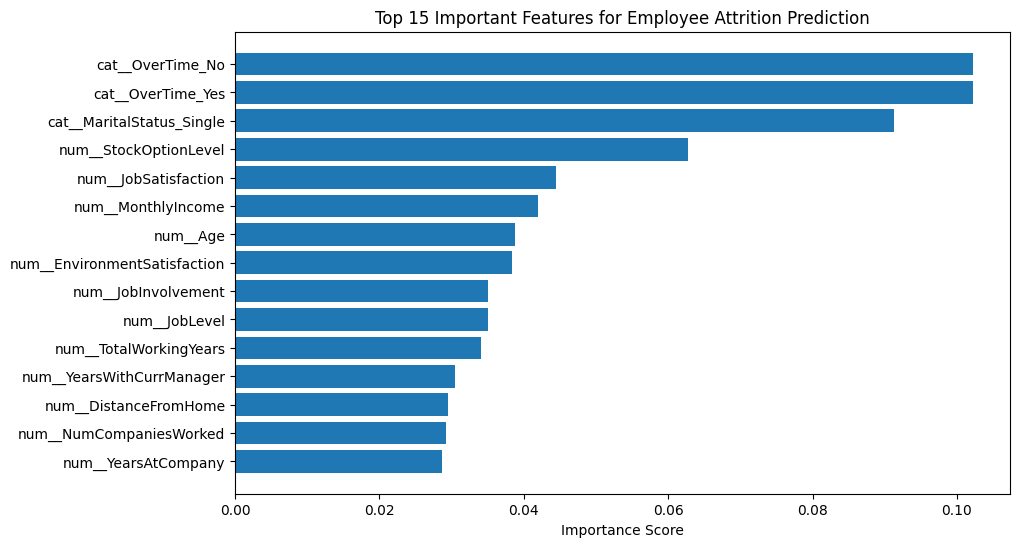


Top Features Influencing Attrition:
                         Feature  Importance
2               cat__OverTime_No    0.102262
3              cat__OverTime_Yes    0.102186
1      cat__MaritalStatus_Single    0.091359
18         num__StockOptionLevel    0.062719
12          num__JobSatisfaction    0.044404
13            num__MonthlyIncome    0.041994
4                       num__Age    0.038807
8   num__EnvironmentSatisfaction    0.038412
10           num__JobInvolvement    0.035004
11                 num__JobLevel    0.034979

Performance for Gender = Male
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       147
           1       0.78      0.23      0.35        31

    accuracy                           0.85       178
   macro avg       0.82      0.61      0.63       178
weighted avg       0.84      0.85      0.82       178


Performance for Gender = Female
              precision    recall  f1-score   support

           0       0.8

In [18]:
# 1️⃣ Feature Importance Analysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get feature importances from the RandomForest model
importances = best_pipe.named_steps['model'].feature_importances_

# Get the feature names after one-hot encoding and feature selection
# We need to get the feature names from the preprocessor first, then apply the selection mask
ohe_feature_names = best_pipe.named_steps['preprocess'].get_feature_names_out()
selected_feature_mask = best_pipe.named_steps['select'].get_support()
selected_feature_names = ohe_feature_names[selected_feature_mask]


importance_df = pd.DataFrame({'Feature': selected_feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Important Features for Employee Attrition Prediction")
plt.xlabel("Importance Score")
plt.show()

print("\nTop Features Influencing Attrition:")
print(importance_df.head(10))

# 2️⃣ Bias/Fairness Check for Gender and Age
from sklearn.metrics import classification_report

def subgroup_performance(subgroup_col, subgroup_value, X_test, y_test, pipe):
    mask = X_test[subgroup_col] == subgroup_value
    X_test_sub = X_test[mask]
    y_true_sub = y_test[mask]
    if len(y_true_sub) == 0:
        print(f"\nNo data for {subgroup_col} = {subgroup_value}")
        return
    y_pred_sub = pipe.predict(X_test_sub)
    print(f"\nPerformance for {subgroup_col} = {subgroup_value}")
    print(classification_report(y_true_sub, y_pred_sub, zero_division=0))


# Gender bias check
subgroup_performance('Gender', 'Male', X_test, y_test, best_pipe)
subgroup_performance('Gender', 'Female', X_test, y_test, best_pipe)

# Age bias check (you can bucketize age)
X_test_age = X_test.copy()
X_test_age['AgeGroup'] = pd.cut(X_test_age['Age'], bins=[0, 30, 50, 100], labels=['Young', 'Mid', 'Senior'])
for group in ['Young', 'Mid', 'Senior']:
    subgroup_performance('AgeGroup', group, X_test_age, y_test, best_pipe)


# 3️⃣ Algorithm Comparison
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

models = {
    "RandomForest": RandomForestClassifier(n_estimators=600, random_state=42, class_weight='balanced', n_jobs=-1),
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=-1 if hasattr(LogisticRegression(), "n_jobs") else None),
}

results = []
for name, clf in models.items():
    pipe = ImbPipeline(steps=[
        ('preprocess', preprocess),
        ('select', feature_selector),
        ('smote', SMOTE(random_state=42)),
        ('model', clf)
    ])
    pipe.fit(X_train, y_train)
    y_pred_temp = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred_temp)
    prec = precision_score(y_test, y_pred_temp, zero_division=0)
    rec = recall_score(y_test, y_pred_temp)
    f1 = f1_score(y_test, y_pred_temp, zero_division=0)
    results.append([name, acc, prec, rec, f1])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
print("\nModel Comparison Table:")
print(results_df)